# Policy-value verification

This notebook demonstrates the PVV module for analysis of global results.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`


In [2]:
using AdaStress
using BSON
using Flux
using Random

In [3]:
@time AdaStress.enable()

100.658170 seconds (29.10 M allocations: 1.782 GiB, 0.73% gc time, 7.29% compilation time)


┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:93
┌ Info: Enabled submodule PolicyValueVerification.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:93


In [4]:
using AdaStress.PolicyValueVerification
using AdaStress.SoftActorCritic

## Load networks

In [5]:
BSON.@load "ac.bson" ac

In [6]:
network = PolicyValueVerification.mean_network(ac; act_mins=-3*ones(2), act_maxs=3*ones(2));

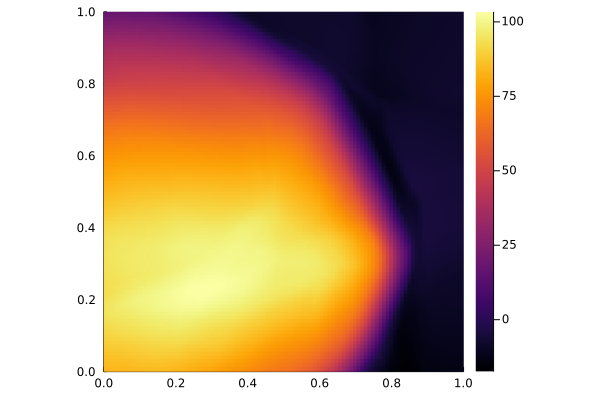

In [7]:
cs = CrossSection((x1, x2) -> (x1, x2, 0.0))
limits = ([0.0, 0.0], [1.0, 1.0])
nnet = cross_section(network, cs, limits)
p = PolicyValueVerification.visualize(nnet, limits)

## Single-process refinement

In [8]:
threshold = 1e-12

1.0e-12

In [9]:
value_cutoff = 100 + log(threshold)
r = BinaryRefinery(network=nnet, val=value_cutoff, tol=1e-3, ks=[3, 6]);

In [10]:
tree = analyze(r, limits);

Cells awaiting processing: 0 	 Time: 0:01:54m


Vol. proportion proven true  : 0.5944290161132812
Vol. proportion proven false : 0.4020843505859375
Vol. proportion unproven     : 0.00348663330078125
Total size of spanning tree  : 2779 leaves
Total size of tree in memory : 474.224 kB
Maximum depth of tree        : 10
Processor balancing score    : NaN


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


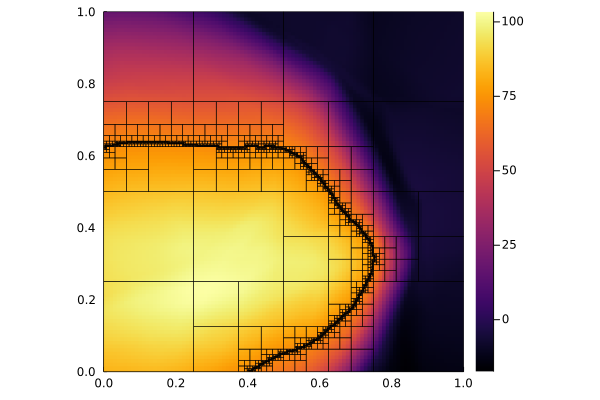

In [11]:
visualize(p, tree; tol=1e-3) # no coloring

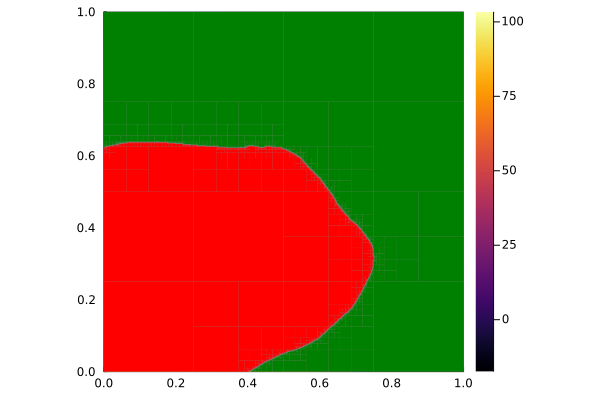

In [12]:
visualize(p, tree; fill=:proof, tol=1e-3) # coloring by proof status

## Multiprocess refinement

The analysis can be distributed over any number of cores, with the workload dynamically balanced across available processors. This is recommended in most cases, especially for high-dimensional and/or low-tolerance refinements.

Loading AdaStress on multiple processes requires careful invocation of Julia's distributed functionality, due to the non-atomicity of environment commands. See the example below for proper code loading.

In [13]:
using Distributed
addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [14]:
@everywhere using Pkg

In [15]:
foreach(i -> remotecall_fetch(Pkg.activate, i, Pkg.project().path), workers()) # should not be called with @everywhere

      From worker 2:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 3:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 4:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 5:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`


In [16]:
@everywhere using AdaStress

In [17]:
foreach(i -> remotecall_fetch(AdaStress.load, i), workers()) # should not be called with @everywhere

      From worker 2:	[ Info: Loaded submodule SoftActorCritic.
      From worker 2:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 3:	[ Info: Loaded submodule SoftActorCritic.
      From worker 3:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 4:	[ Info: Loaded submodule SoftActorCritic.
      From worker 4:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 5:	[ Info: Loaded submodule SoftActorCritic.
      From worker 5:	[ Info: Loaded submodule PolicyValueVerification.


In [18]:
@everywhere using AdaStress.PolicyValueVerification

In [19]:
tree_mp = analyze(r, limits);

Cells awaiting processing: 0 	 Time: 0:00:49mm


Vol. proportion proven true  : 0.5944290161132812
Vol. proportion proven false : 0.4020843505859375
Vol. proportion unproven     : 0.00348663330078125
Total size of spanning tree  : 2779 leaves
Total size of tree in memory : 474.224 kB
Maximum depth of tree        : 10
Processor balancing score    : 0.9898624698503617


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


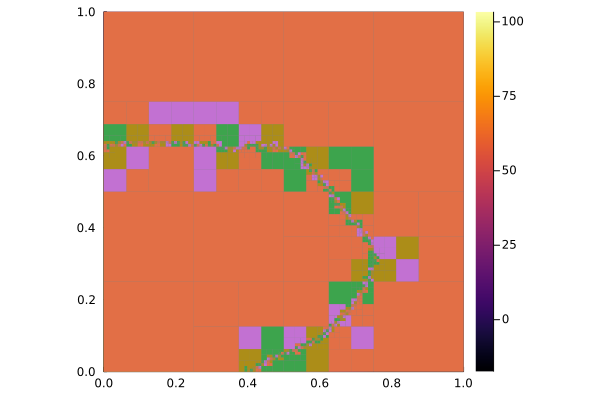

In [20]:
visualize(p, tree_mp; fill=:pid, tol=1e-3) # coloring by process id